# Denoising Autoencoder with MNIST Digits

Import modules, upload mnist data, data normalization, apply noise

In [1]:
import random
import copy
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 8s 1us/step


Data normalization to values in range [0-1] and reshape to array suitable for network

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Apply noise with noise factor 0.5

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

That is how the first 10 noisy input images looks like

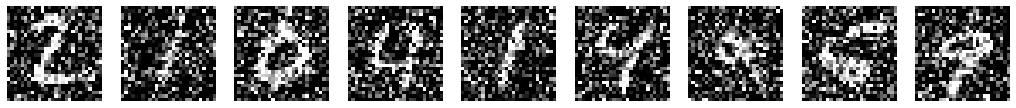

In [36]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convolutional AutoEncoder model

In [0]:
input_img = Input(shape=(28, 28, 1))  # shape of the images that wil be on input

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Train network for 100 epochs with noisy images as input and correct images as desired output

In [38]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.1816 - val_loss: 0.1231
Epoch 2/100
 - 7s - loss: 0.1173 - val_loss: 0.1106
Epoch 3/100
 - 7s - loss: 0.1104 - val_loss: 0.1070
Epoch 4/100
 - 7s - loss: 0.1071 - val_loss: 0.1044
Epoch 5/100
 - 7s - loss: 0.1051 - val_loss: 0.1045
Epoch 6/100
 - 7s - loss: 0.1038 - val_loss: 0.1038
Epoch 7/100
 - 7s - loss: 0.1027 - val_loss: 0.1008
Epoch 8/100
 - 7s - loss: 0.1018 - val_loss: 0.1043
Epoch 9/100
 - 7s - loss: 0.1013 - val_loss: 0.1009
Epoch 10/100
 - 7s - loss: 0.1009 - val_loss: 0.0995
Epoch 11/100
 - 7s - loss: 0.1003 - val_loss: 0.0988
Epoch 12/100
 - 7s - loss: 0.1001 - val_loss: 0.0998
Epoch 13/100
 - 7s - loss: 0.0998 - val_loss: 0.0990
Epoch 14/100
 - 7s - loss: 0.0994 - val_loss: 0.0986
Epoch 15/100
 - 7s - loss: 0.0991 - val_loss: 0.0981
Epoch 16/100
 - 7s - loss: 0.0988 - val_loss: 0.0978
Epoch 17/100
 - 7s - loss: 0.0986 - val_loss: 0.0978
Epoch 18/100
 - 7s - loss: 0.0983 - val_loss: 0.0972
Epoch

Testing the denoising autoencoder and visualizing images on input and output of autoencoder

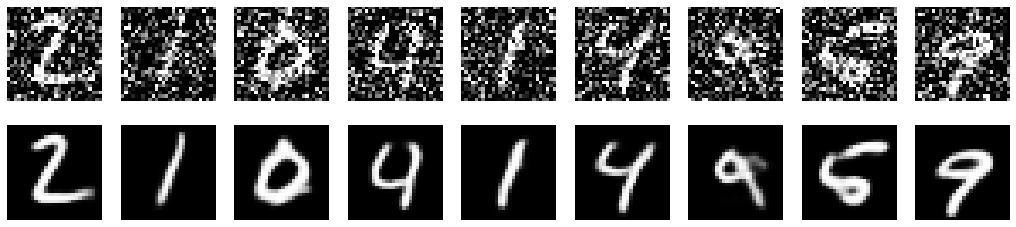

In [39]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Now, let's do the inpainting autoencoder

First we must create data for training and testing, so we apply randomly 5 stripes on images

In [0]:
stripes_no = 10
x_train_inpaint = copy.deepcopy(x_train)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(28), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((28,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(28), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((28,1))

Visualizing input images with stripes

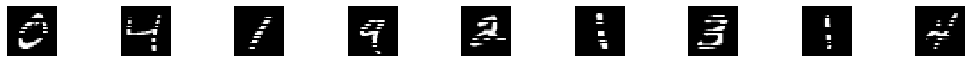

In [46]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fit into the same network model once again but know the images with stripes

In [48]:
autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_inpaint, x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.0929 - val_loss: 0.0898
Epoch 2/100
 - 7s - loss: 0.0896 - val_loss: 0.0880
Epoch 3/100
 - 7s - loss: 0.0879 - val_loss: 0.0883
Epoch 4/100
 - 7s - loss: 0.0868 - val_loss: 0.0847
Epoch 5/100
 - 7s - loss: 0.0860 - val_loss: 0.0859
Epoch 6/100
 - 7s - loss: 0.0852 - val_loss: 0.0875
Epoch 7/100
 - 7s - loss: 0.0848 - val_loss: 0.0851
Epoch 8/100
 - 7s - loss: 0.0844 - val_loss: 0.0834
Epoch 9/100
 - 7s - loss: 0.0840 - val_loss: 0.0824
Epoch 10/100
 - 7s - loss: 0.0836 - val_loss: 0.0842
Epoch 11/100
 - 7s - loss: 0.0833 - val_loss: 0.0846
Epoch 12/100
 - 7s - loss: 0.0832 - val_loss: 0.0842
Epoch 13/100
 - 7s - loss: 0.0830 - val_loss: 0.0825
Epoch 14/100
 - 7s - loss: 0.0828 - val_loss: 0.0822
Epoch 15/100
 - 7s - loss: 0.0825 - val_loss: 0.0812
Epoch 16/100
 - 7s - loss: 0.0823 - val_loss: 0.0814
Epoch 17/100
 - 7s - loss: 0.0822 - val_loss: 0.0819
Epoch 18/100
 - 7s - loss: 0.0822 - val_loss: 0.0815
Epoch

Now tests and visualization

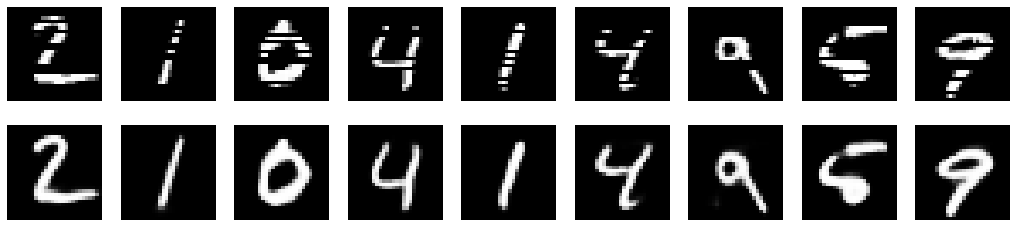

In [49]:
decoded_imgs = autoencoder.predict(x_test_inpaint)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_inpaint[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Another inpainting experiment, now with blocks

Creating data from dataset images with randomly placed gray block of size 10x10

In [0]:
block_size = 10
x_train_inpaint_block = copy.deepcopy(x_train)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,28-block_size)
    y = random.randint(0,28-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,28-block_size)
    y = random.randint(0,28-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

Visualization of input images with the gray blocks

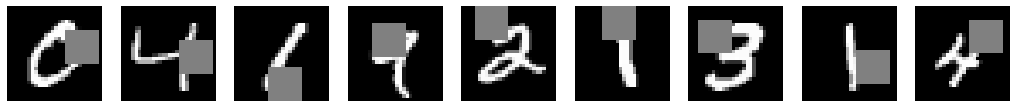

In [51]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fit into the same network model once again but know with the images with grayblocks

In [52]:
autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_inpaint_block, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.1012 - val_loss: 0.0967
Epoch 2/100
 - 7s - loss: 0.0956 - val_loss: 0.0938
Epoch 3/100
 - 7s - loss: 0.0937 - val_loss: 0.0934
Epoch 4/100
 - 7s - loss: 0.0925 - val_loss: 0.0918
Epoch 5/100
 - 7s - loss: 0.0919 - val_loss: 0.0918
Epoch 6/100
 - 7s - loss: 0.0913 - val_loss: 0.0906
Epoch 7/100
 - 7s - loss: 0.0909 - val_loss: 0.0900
Epoch 8/100
 - 7s - loss: 0.0904 - val_loss: 0.0901
Epoch 9/100
 - 7s - loss: 0.0901 - val_loss: 0.0896
Epoch 10/100
 - 7s - loss: 0.0899 - val_loss: 0.0896
Epoch 11/100
 - 7s - loss: 0.0896 - val_loss: 0.0896
Epoch 12/100
 - 7s - loss: 0.0894 - val_loss: 0.0899
Epoch 13/100
 - 7s - loss: 0.0892 - val_loss: 0.0889
Epoch 14/100
 - 7s - loss: 0.0890 - val_loss: 0.0888
Epoch 15/100
 - 7s - loss: 0.0888 - val_loss: 0.0889
Epoch 16/100
 - 7s - loss: 0.0887 - val_loss: 0.0881
Epoch 17/100
 - 7s - loss: 0.0885 - val_loss: 0.0892
Epoch 18/100
 - 7s - loss: 0.0884 - val_loss: 0.0901
Epoch

Now tests and visualization

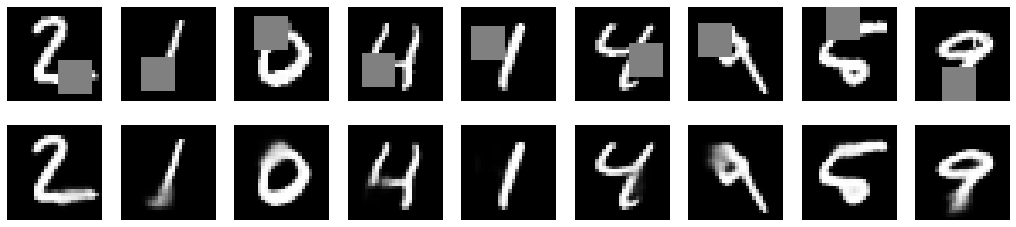

In [53]:
decoded_imgs = autoencoder.predict(x_test_inpaint_block)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_inpaint_block[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Using Denoising Autoencoder as a Generative model

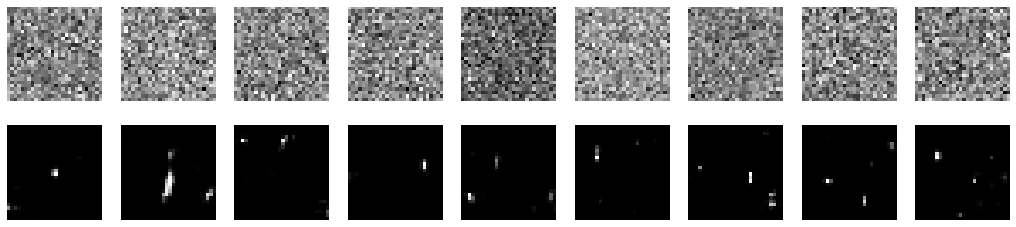

In [70]:
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(10,28,28,1)) 

decoded_imgs = autoencoder.predict(noise)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
